# Predicting Cryptocurrency price using LSTM

## Get data
We will use the `get_data.py` script that is prepared to get data from a given crypto since given date

In [1]:
!python3 get_data.py --crypto-name BTC --start-date 2014-1-1 --save-path btc-usd_data.parquet

BTC
[*********************100%%**********************]  1 of 1 completed
<class 'pandas.core.frame.DataFrame'>
                  Open        High  ...   Adj Close    Volume
Date                                ...                      
2014-09-17  465.864014  468.174011  ...  457.334015  21056800
2014-09-18  456.859985  456.859985  ...  424.440002  34483200
2014-09-19  424.102997  427.834991  ...  394.795990  37919700
2014-09-20  394.673004  423.295990  ...  408.903992  36863600
2014-09-21  408.084991  412.425995  ...  398.821014  26580100

[5 rows x 6 columns]


## Load data

In [2]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

In [19]:
data = pd.read_parquet("data/btc-usd_data.parquet")
data

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2014-09-17,465.864014,468.174011,452.421997,457.334015,457.334015,21056800
2014-09-18,456.859985,456.859985,413.104004,424.440002,424.440002,34483200
2014-09-19,424.102997,427.834991,384.532013,394.795990,394.795990,37919700
2014-09-20,394.673004,423.295990,389.882996,408.903992,408.903992,36863600
2014-09-21,408.084991,412.425995,393.181000,398.821014,398.821014,26580100
...,...,...,...,...,...,...
2024-05-10,63055.191406,63446.742188,60208.781250,60792.777344,60792.777344,27804954694
2024-05-11,60793.355469,61451.152344,60492.625000,60793.710938,60793.710938,13842272968
2024-05-12,60793.503906,61818.156250,60632.601562,61448.394531,61448.394531,13800459405


## Split data

We are going to use data between 2014 and 2022 for training and between 2022 and 2023 for testing

In [41]:
train = data[:"2023"]["Close"]
test = data["2023":]["Close"]

In [42]:
train

Date
2014-09-17      457.334015
2014-09-18      424.440002
2014-09-19      394.795990
2014-09-20      408.903992
2014-09-21      398.821014
                  ...     
2023-12-27    43442.855469
2023-12-28    42627.855469
2023-12-29    42099.402344
2023-12-30    42156.902344
2023-12-31    42265.187500
Name: Close, Length: 3393, dtype: float64

In [43]:
test

Date
2023-01-01    16625.080078
2023-01-02    16688.470703
2023-01-03    16679.857422
2023-01-04    16863.238281
2023-01-05    16836.736328
                  ...     
2024-05-10    60792.777344
2024-05-11    60793.710938
2024-05-12    61448.394531
2024-05-13    62901.449219
2024-05-14    61647.687500
Name: Close, Length: 500, dtype: float64

In [44]:
len(train), len(test)

(3393, 500)

In [45]:
len(test)/len(train)

0.14736221632773358

## Preprocess data

### Scale to 0-1 range

In [46]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler(feature_range=(0, 1))
train_scaled = scaler.fit_transform(train.values.reshape(-1, 1))

In [47]:
train_scaled

array([[0.00414359],
       [0.00365546],
       [0.00321557],
       ...,
       [0.6220818 ],
       [0.62293506],
       [0.62454193]])

In [48]:
train_scaled.min(), train_scaled.max()

(0.0, 1.0)

### Generate batches of N days

In [67]:
prediction_days = 60

X_train, y_train = [], []

for x in range(prediction_days, len(train_scaled)):
    X_train.append(train_scaled[x-prediction_days:x, 0])
    y_train.append(train_scaled[x, 0])

X_train, y_train = np.array(X_train), np.array(y_train)
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))

In [68]:
X_train.shape

(3333, 60, 1)

## Create the model

### Model 1: One layer with 32 neurons

In [144]:
from tensorflow.keras.layers import Dense, Dropout, LSTM
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam, SGD, RMSprop

model1 = Sequential()
model1.add(LSTM(units=32, return_sequences=False, input_shape=(X_train.shape[1], 1)))
model1.add(Dropout(0.10))
model1.add(Dense(units=1))
model1.compile(optimizer=Adam(learning_rate=0.0005), loss="mse")

### Model 2: One layer with 64 neurons

In [145]:
model2 = Sequential()
model2.add(LSTM(units=64, return_sequences=False, input_shape=(X_train.shape[1], 1)))
model2.add(Dropout(0.20))
model2.add(Dense(units=1))
model2.compile(optimizer=Adam(learning_rate=0.0005), loss="mse")

### Model 3: Two layers with 32 neurons

In [146]:
model3 = Sequential()
model3.add(LSTM(units=32, return_sequences=True, input_shape=(X_train.shape[1], 1)))
model3.add(Dropout(0.2))
model3.add(LSTM(units=32, return_sequences=False))
model3.add(Dropout(0.2))
model3.add(Dense(units=1))
model3.compile(optimizer=Adam(learning_rate=0.0005), loss="mse")

## Train models

In [147]:
epochs = 50
batch_size = 32

### Model 1

In [148]:
model1.summary()

Model: "sequential_10"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_17 (LSTM)              (None, 32)                4352      
                                                                 
 dropout_13 (Dropout)        (None, 32)                0         
                                                                 
 dense_8 (Dense)             (None, 1)                 33        
                                                                 
Total params: 4385 (17.13 KB)
Trainable params: 4385 (17.13 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [149]:
model1_history = model1.fit(X_train, y_train, epochs=epochs, batch_size=batch_size, verbose=0)

### Model 2

In [150]:
model2.summary()

Model: "sequential_11"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_18 (LSTM)              (None, 64)                16896     
                                                                 
 dropout_14 (Dropout)        (None, 64)                0         
                                                                 
 dense_9 (Dense)             (None, 1)                 65        
                                                                 
Total params: 16961 (66.25 KB)
Trainable params: 16961 (66.25 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [151]:
model2_history = model2.fit(X_train, y_train, epochs=epochs, batch_size=batch_size, verbose=0)

### Model 3

In [152]:
model3.summary()

Model: "sequential_12"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_19 (LSTM)              (None, 60, 32)            4352      
                                                                 
 dropout_15 (Dropout)        (None, 60, 32)            0         
                                                                 
 lstm_20 (LSTM)              (None, 32)                8320      
                                                                 
 dropout_16 (Dropout)        (None, 32)                0         
                                                                 
 dense_10 (Dense)            (None, 1)                 33        
                                                                 
Total params: 12705 (49.63 KB)
Trainable params: 12705 (49.63 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [153]:
model3_history = model3.fit(X_train, y_train, epochs=epochs, batch_size=batch_size, verbose=0)

## Training curves

In [125]:
sns.set_style()

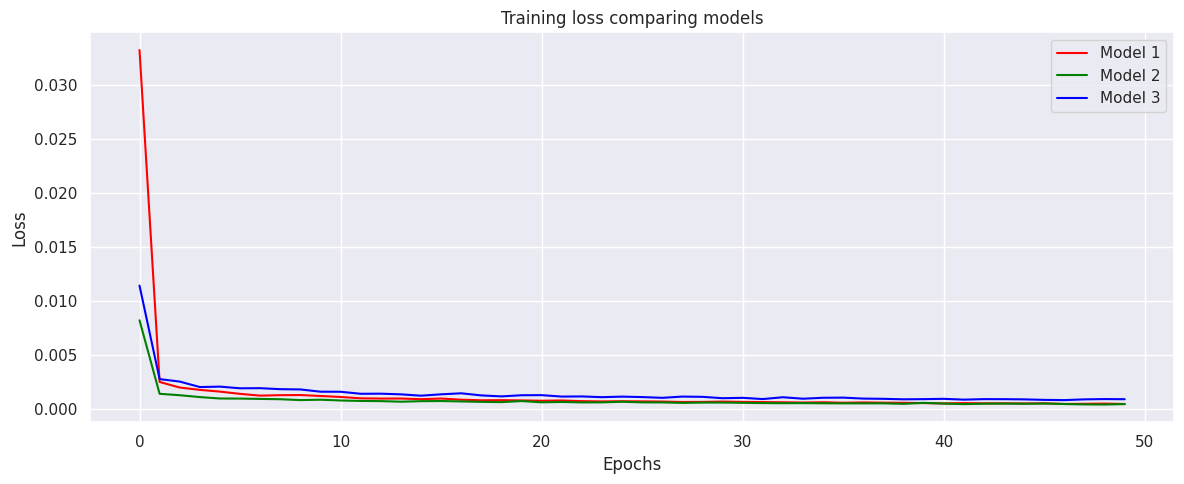

In [158]:
loss1 = model1_history.history['loss']
loss2 = model2_history.history['loss']
loss3 = model3_history.history['loss']

# Establecer el fondo en gris oscuro y la rejilla en blanco
sns.set_style("darkgrid")
# Crear el gráfico de pérdida usando Seaborn
plt.figure(figsize=(12, 5))
sns.lineplot(data=loss1, dashes=False, label="Model 1", color="red")
sns.lineplot(data=loss2, dashes=False, label="Model 2", color="green")
sns.lineplot(data=loss3, dashes=False, label="Model 3", color="blue")

# Personalizar el gráfico
# plt.legend(labels=['Model 1 loss', 'Model 2 loss', 'Model 3 loss'])
plt.title('Training loss comparing models')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.tight_layout()
# sns.despine()
# Guardar el gráfico
plt.savefig("LSTM_training_model_compare.jpg", dpi=200)
# Mostrar el gráfico
plt.show()

## Test model

### Generate test batches

In [159]:
test_scaled = scaler.transform(test.values.reshape(-1, 1))

prediction_days = 60

X_test, y_test = [], []

for x in range(prediction_days, len(test_scaled)):
    X_test.append(test_scaled[x-prediction_days:x, 0])
    y_test.append(test_scaled[x, 0])

X_test, y_test = np.array(X_test), np.array(y_test)
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))

In [161]:
# Predict using each model
prediction_model1 = model1.predict(X_test)
prediction_model2 = model2.predict(X_test)
prediction_model3 = model3.predict(X_test)

# Inverse scale to predictions
prediction_model1 = scaler.inverse_transform(prediction_model1)
prediction_model2 = scaler.inverse_transform(prediction_model2)
prediction_model3 = scaler.inverse_transform(prediction_model3)

# Reshape true values
y_true = scaler.inverse_transform(y_test.reshape(-1, 1))

14/14 [==============================] - 6s 12ms/step


In [162]:
prediction_model1.shape, y_true.shape

((440, 1), (440, 1))

In [86]:
dates = test.iloc[60:]

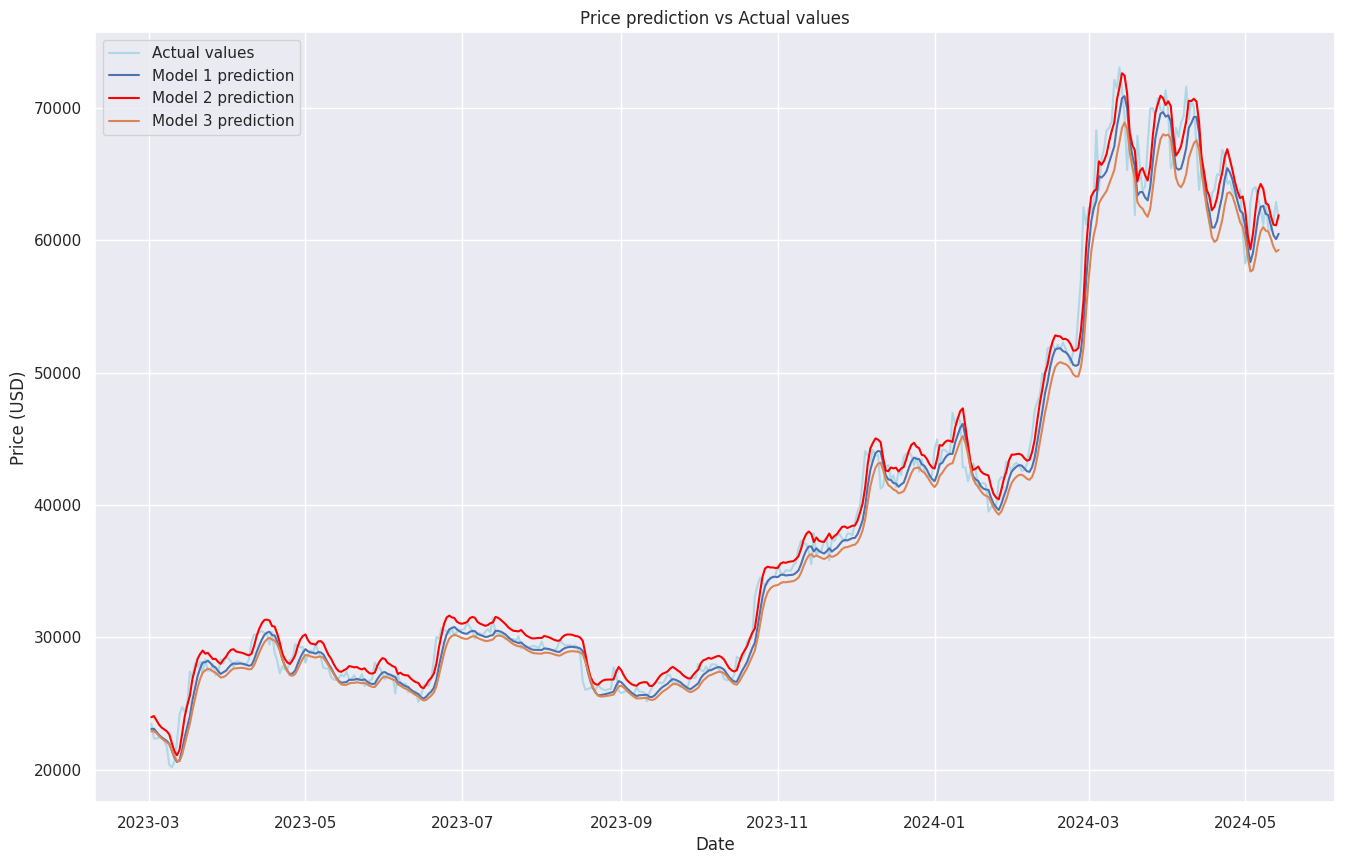

In [167]:
sns.set_style("darkgrid")
plt.figure(figsize=(16,10))
plt.plot(dates.index.date, y_true, label="Actual values", c="lightblue")
plt.plot(dates.index.date, prediction_model1, label="Model 1 prediction")
plt.plot(dates.index.date, prediction_model2, label="Model 2 prediction", c="red")
plt.plot(dates.index.date, prediction_model3, label="Model 3 prediction")
plt.title("Price prediction vs Actual values")
plt.xlabel("Date")
plt.ylabel("Price (USD)")
plt.legend()
# Guardar gráfico
plt.savefig("LSTM_predict_model_compare.jpg", dpi=200)
# Mostrar gráfico
plt.show()